In [1]:
import json
import os
import random
import warnings
from argparse import ArgumentParser
from math import ceil

import librosa
import numpy as np
import pandas as pd
import torch
from datasets import concatenate_datasets, load_dataset
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from datasets import Dataset

warnings.filterwarnings("ignore")

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=0.15
        )

        self.fc = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc2(self.relu(self.fc(out[:, -1, :])))
        return out

class SilenceModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SilenceModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=0.15
        )

        self.fc = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc2(self.relu(self.fc(out[:, -1, :])))
        return out

def calculate_accuracy(preds, y):
    preds = torch.nn.functional.softmax(preds, dim=1)
    preds = torch.argmax(preds, dim=1)
    return (torch.sum(preds == y) / len(y)).item()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
input_size = 12
hidden_size = 64
num_layers = 3
output_size = 2
silence_model = SilenceModel(input_size, hidden_size, num_layers, output_size)
silence_model.load_state_dict(torch.load("silence.pth", map_location=torch.device('cpu')))

id2label = {
    "0": "yes",
    "1": "no",
    "2": "up",
    "3": "down",
    "4": "left",
    "5": "right",
    "6": "on",
    "7": "off",
    "8": "stop",
    "9": "go",
    "10": "_unknown_",
    "11": "_silence_",
}

In [ ]:
lstm_model = LSTMModel(12, 256, 2, len(id2label))
lstm_model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))

In [4]:
def compute_mfcc(data, sample_rate=16000, n_mfcc=12):
    # Extract MFCC features
    # https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
    mfcc = librosa.feature.mfcc(
        y=data,
        sr=sample_rate,
        n_mfcc=n_mfcc,  # How many mfcc features to use? 12 at most.
        # https://dsp.stackexchange.com/questions/28898/mfcc-significance-of-number-of-features
    )
    return mfcc


def extract_fields(example):
    x = example["audio"]["array"]
    return {
        "label": example["label"],
        "array": np.pad(x, (0, 16000 - len(x)), constant_values=0),
    }


def swap_to_unknown(examples):
    examples["label"] = [10] * len(examples["label"])
    return examples


def swap_to_silence(examples):
    examples["label"] = [11] * len(examples["label"])
    return examples


def cut_audio(example):

    if len(example["audio"]["array"]) > 16000:
        example["audio"]["array"] = example["audio"]["array"][:16000]

    return example


def swap_labels_for_data_split(data):
    id2label_org = data.features["label"].int2str
    normal = data.filter(lambda x: id2label_org(x["label"]) in normal_classes)

    class_size = ceil(len(normal) / len(normal_classes))
    to_subsample = data.filter(lambda x: id2label_org(x["label"]) in to_be_subsampled)
    silence = data.filter(lambda x: id2label_org(x["label"]) == "_silence_")

    silence = silence.map(cut_audio)
    to_subsample = to_subsample.map(swap_to_unknown, batched=True)

    if len(to_subsample) > class_size:
        to_subsample = to_subsample.shuffle(seed=42).select(range(class_size))

    to_subsample = to_subsample.map(swap_to_unknown, batched=True)
    silence = silence.map(swap_to_silence, batched=True)
    results = concatenate_datasets([normal, to_subsample, silence])
    return results


def preprocess(speech_data):
    train = speech_data["train"]
    validation = speech_data["validation"]
    test = speech_data["test"]

    train = swap_labels_for_data_split(train)
    validation = swap_labels_for_data_split(validation)
    test = swap_labels_for_data_split(test)

    train = train.map(
        extract_fields, remove_columns=["file", "audio", "speaker_id", "utterance_id"]
    )
    validation = validation.map(
        extract_fields, remove_columns=["file", "audio", "speaker_id", "utterance_id"]
    )
    test = test.map(
        extract_fields, remove_columns=["file", "audio", "speaker_id", "utterance_id"]
    )

    return (
        train.with_format("torch"),
        validation.with_format("torch"),
        test.with_format("torch"),
    )


def calculate_accuracy(preds, y):
    preds = torch.nn.functional.softmax(preds, dim=1)
    preds = torch.argmax(preds, dim=1)
    return (torch.sum(preds == y) / len(y)).item()

normal_classes = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"}
to_be_subsampled = {
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "bed",
    "bird",
    "cat",
    "dog",
    "happy",
    "house",
    "marvin",
    "sheila",
    "tree",
    "wow",
    "backward",
    "forward",
    "follow",
    "learn",
    "visual",
}

id2label = {
    "0": "yes",
    "1": "no",
    "2": "up",
    "3": "down",
    "4": "left",
    "5": "right",
    "6": "on",
    "7": "off",
    "8": "stop",
    "9": "go",
    "10": "_unknown_",
    "11": "_silence_",
}
label2id = {v: k for k, v in id2label.items()}

In [5]:
speech_data = load_dataset(
    "speech_commands", "v0.02", cache_dir="only_selected/data_here"
)

train, validation, test = preprocess(speech_data)

In [6]:
class MergedModel:
    def __init__(self, silence_pred, other_pred) -> None:
        self.silence_pred = silence_pred
        self.other_pred = other_pred

    def eval(self):
        self.silence_pred.eval()
        self.other_pred.eval()

    def __call__(self, x):
        silence_pred = self.silence_pred(x)
        silence_label = torch.nn.functional.softmax(silence_pred, dim=1)
        silence_pred = torch.argmax(silence_label, dim=1)
        if silence_pred.item() == 1:
            return 11
        else:
            temp = nn.functional.softmax(self.other_pred(x), dim=1)
            return torch.argmax(temp, dim=1).item()

In [9]:
# model = MergedModel(silence_model, lstm_model)

In [7]:
def eval_model_accuracy(model):
    test_loader = DataLoader(test)

    def calculate_accuracy(preds, y):
        return (torch.sum(preds == y) / len(y))

    model.eval()
    test_accuracy = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            x = batch["array"]
            x = (
                torch.Tensor(compute_mfcc(np.array(x), 16_000))
                .permute(0, 2, 1)
                .to(device)
            )
            y = batch["label"].to(device)
            y_pred = model(x.float())
            test_accuracy += calculate_accuracy(y_pred, y)
            predictions.append(y_pred)
            true_labels.append(y)
    test_accuracy = test_accuracy / len(test_loader)

    print(f"Test accuracy: {test_accuracy}")
    return (predictions, true_labels, test_accuracy)

In [15]:
predictions, true_labels, acc = eval_model_accuracy(model)

Test accuracy: 0.8638036847114563


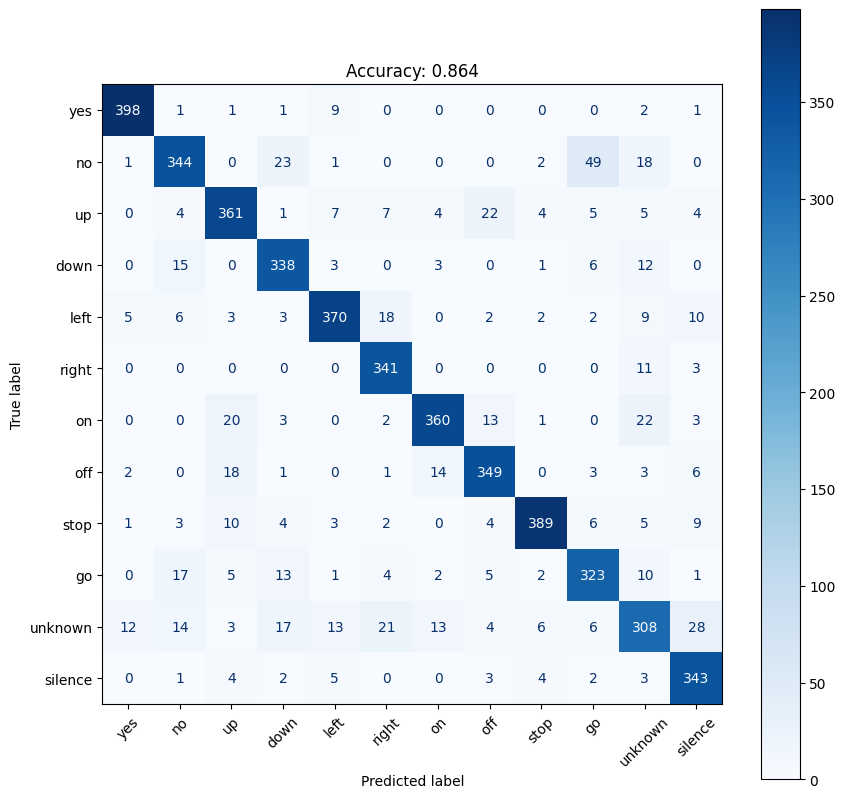

In [18]:
save_confusion_matrix(predictions, true_labels, acc, "confusion_matrix_lstm_with_silence.png")

In [63]:
from transformers import AutoModelForAudioClassification
path = '../whisper/checkpoints/pretrained/Teapack1_whisper_tiny_finetuned_no_go_kws_seed_1/checkpoint-165'

whisper_model = AutoModelForAudioClassification.from_pretrained(path)

In [93]:
from transformers import AutoFeatureExtractor
test_loader = DataLoader(test, batch_size=1)
feature_extractor = AutoFeatureExtractor.from_pretrained('Teapack1/whisper-tiny-finetuned-no-go-kws')

In [110]:
def calculate_accuracy(preds, y):
    return (torch.sum(preds == y) / len(y))
from tqdm import tqdm

silence_model.eval()
whisper_model.eval()

test_accuracy = 0.0
predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        x = batch["array"]
        
        x_preprocess = feature_extractor(list(batch['array'].numpy()), sampling_rate=16_000, padding=True, return_tensors='pt')
        x = (
            torch.Tensor(compute_mfcc(np.array(x), 16_000))
            .permute(0, 2, 1)
            .to(device)
        )
        y = batch["label"].to(device)
        if_silence = silence_model(x.float())
        if_silence = torch.nn.functional.softmax(if_silence, dim=1)
        silence_pred = torch.argmax(if_silence, dim=1)
        if silence_pred.item() == 1:
            result = 11
        else:
            y_pred = whisper_model(x_preprocess['input_features']).logits
            y_pred = torch.argmax(y_pred, dim=1)
            result = y_pred.item()
        test_accuracy += calculate_accuracy(result, y)
        predictions.append(result)
        true_labels.append(y)
test_accuracy = test_accuracy / len(test_loader)

print(f"Test accuracy: {test_accuracy}")

  0%|          | 1/4890 [00:00<08:43,  9.34it/s]

100%|██████████| 4890/4890 [05:23<00:00, 15.09it/s]

Test accuracy: 0.95030677318573


In [17]:
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

LABELS = ["yes", "no", "up", "down",
          "left", 'right', 'on', 'off', 
          'stop', 'go', 'unknown', 'silence']

def save_confusion_matrix(true_labels, predicted_labels, acc, filename):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues")
    plt.xticks(rotation=45)
    plt.title(f"Accuracy: {acc:.3f}")
    plt.savefig(filename)

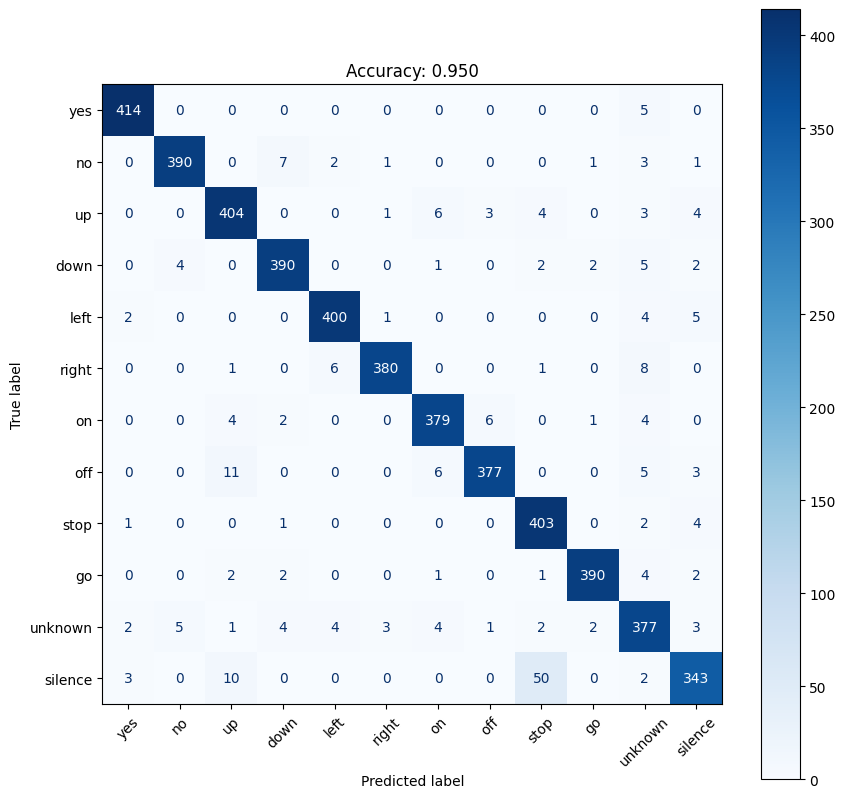

In [113]:
save_confusion_matrix(true_labels, predictions, test_accuracy, "confusion_matrix_whisper_with_silence.png")

# AST

In [8]:
from transformers import AutoModelForAudioClassification
from transformers import WhisperConfig
path = '../AST/checkpoints/pretrained/MIT_ast_finetuned_speech_commands_v2_seed_1/checkpoint-99/'

ast_model = AutoModelForAudioClassification.from_pretrained(path)

In [9]:
from transformers import AutoFeatureExtractor

test_loader = DataLoader(test, batch_size=1)
feature_extractor = AutoFeatureExtractor.from_pretrained('MIT/ast-finetuned-speech-commands-v2')

In [20]:
def calculate_accuracy(preds, y):
    return (torch.sum(preds == y) / len(y))
from tqdm import tqdm

silence_model.to(device)
ast_model.to(device)

silence_model.eval()
ast_model.eval()

test_accuracy = 0.0
predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        x = batch["array"]
        x = (
            torch.Tensor(compute_mfcc(np.array(x), 16_000))
            .permute(0, 2, 1)
            .to(device)
        )
        y = batch["label"].to(device)
        if_silence = silence_model(x.float())
        if_silence = torch.nn.functional.softmax(if_silence, dim=1)
        silence_pred = torch.argmax(if_silence, dim=1)
        if silence_pred.item() == 1:
            result = 11
        else:
            x_preprocess = feature_extractor(list(batch['array'].numpy()), sampling_rate=16_000, padding=True, return_tensors='pt')
            y_pred = ast_model(x_preprocess['input_values'].to(device)).logits
            y_pred = torch.argmax(y_pred, dim=1)
            result = y_pred.item()
        test_accuracy += calculate_accuracy(result, y)
        predictions.append(result)
        true_labels.append(y.item())
test_accuracy = test_accuracy / len(test_loader)

print(f"Test accuracy: {test_accuracy}")

100%|██████████| 4890/4890 [00:56<00:00, 86.25it/s] 

Test accuracy: 0.9713701605796814


In [24]:
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

LABELS = ["yes", "no", "up", "down",
          "left", 'right', 'on', 'off', 
          'stop', 'go', 'unknown', 'silence']

def save_confusion_matrix(true_labels, predicted_labels, acc, filename):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues")
    plt.xticks(rotation=45)
    plt.title(f"Accuracy: {acc:.3f}")
    plt.savefig(filename)

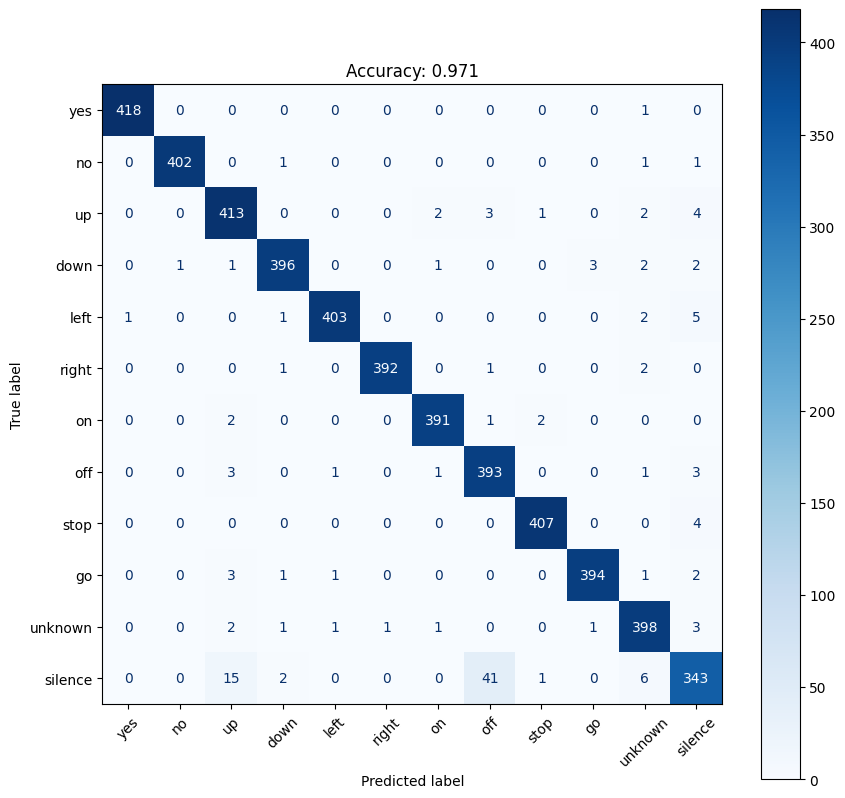

In [25]:
save_confusion_matrix(true_labels, predictions, test_accuracy, "../AST/checkpoints/pretrained/MIT_ast_finetuned_speech_commands_v2_seed_1/confusion_matrix_whisper_with_silence.png")